## TFIM (磁化, EE, 横磁場, 分割しない, 周期境界条件なし)

\[
H = - J \sum_i S_i^z S_{i+1}^z \;-\; h_x \sum_i S_i^x
\]

In [1]:
import qutip as qt
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
from pathlib import Path
from datetime import datetime
import matplotlib.patheffects as pe
from matplotlib.gridspec import GridSpec
import matplotlib.patheffects as pe

In [2]:
# ============
## 準備
T_total, nt = 20.0, 400
tlist = np.linspace(0.0, T_total, nt)
# ============
## 実行部
# cut_pos = N // 2 - 1
# sx, sy, sz = [0.5*M for M in (qt.sigmax(), qt.sigmay(), qt.sigmaz())]
# I2 = qt.qeye(2)
# # iのスピン演算子に関するハミルトニアンの項
# Sx = [op_at(i, sx) for i in range(N)]
# Sy = [op_at(i, sy) for i in range(N)]
# Sz = [op_at(i, sz) for i in range(N)]
# # ハミルトニアン
# ## 分割するボンド
# H_cut_unit = H_exchange(cut_pos)
# ## それ以外のボンド
# H_exchange_unit = sum(H_exchange(i) for i in range(N) if i != cut_pos)
# ## 横磁場項
# H_trans_unit = sum(H_trans(i) for i in range(N))
# H_full = -J * (H_exchange_unit + H_cut_unit) - h[0] * H_trans_unit
# H_static = -J * H_exchange_unit - h[0] * H_trans_unit
# left_sides = [i for i in range(cut_pos + 1)]
# _, psi_ground = H_full.groundstate(sparse=True)
# solver_opts = dict(store_states=False, progress_bar = None, rtol = 1e-6, atol=1e-8, nsteps=20000)
# ============


# まとめて N, h, J, T_cutをパラメータとして 
def simulate(N, J, hx_list):
    sx, sy, sz = qt.sigmax(), qt.sigmay(), qt.sigmaz()
    I2 = qt.qeye(2)

    # ============
    # ハミルトニアン構築
    def op_at(i, op):
        return qt.tensor([op if k == i else I2 for k in range(N)])

    Sx = [op_at(i, sx) for i in range(N)]
    Sy = [op_at(i, sy) for i in range(N)]
    Sz = [op_at(i, sz) for i in range(N)]
    
    # イジング相互作用項
    def H_exchange(i):
        return (Sz[i] * Sz[i+1])
    
    # 横磁場項
    def H_trans(i):
        return Sx[i]
    # ============
    H_exchange_unit = sum(H_exchange(i) for i in range(N-1))
    H_trans_unit = sum(H_trans(i) for i in range(N))
    # H_full = -J * (H_exchange_unit) - hx * H_trans_unit
    # _, psi0 = H_full.groundstate(sparse=True)
    solver_opts = dict(store_states=False, progress_bar = None, rtol = 1e-6, atol=1e-8, nsteps=20000)
    Sx_tot, Sz_tot = sum(Sx), sum(Sz)
    # ============
    ## sigma_xとsigma_zの期待値をそれぞれプロット
    hx_arr = np.asarray(hx_list, dtype=float)
    Mx_vals, Mz_vals, SA_vals = [], [], []

    left_side = list(range(N//2))
    for hx in hx_arr:
        H_full = -J * H_exchange_unit - hx * H_trans_unit
        _, psi0 = H_full.groundstate(sparse=True)

        # テスト
        # H_test = - 1.0 * H_exchange_unit
        # e0, psi0 = H_test.groundstate(sparse=True)
        # print(e0)
        # print(psi0)
        # return

        # 磁化
        Mx_vals.append(2.0/N * qt.expect(Sx_tot, psi0))
        Mz_vals.append(2.0/N * qt.expect(Sz_tot, psi0))

        # EE
        rhoL = psi0.ptrace(left_side)
        SA_vals.append(qt.entropy_vn(rhoL, base=2))
        
    return (
        (hx_arr, np.real_if_close(Mx_vals)),
        (hx_arr, np.real_if_close(Mz_vals)),
        (hx_arr, np.asarray(SA_vals, dtype=float)),
    )




/Users/naoki/Desktop/RESEARCH/実験/venv/lib/python3.13/site-packages/qutip/core/qobj.py:1769: UserWarning: Ground state may be degenerate.
  warnings.warn("Ground state may be degenerate.", UserWarning)


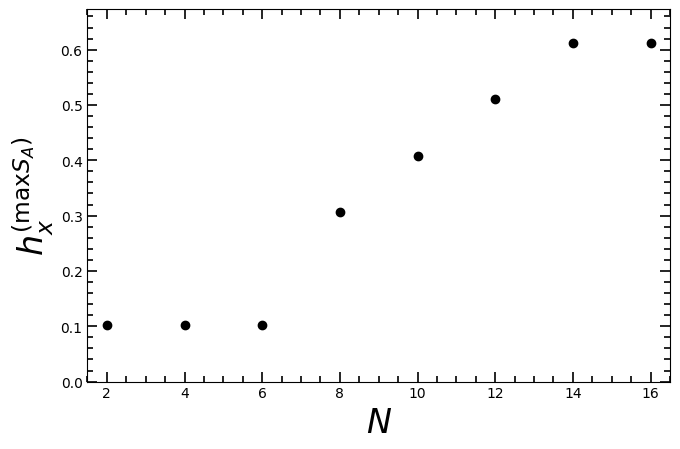

In [3]:
N_list = [2, 4, 6, 8, 10, 12, 14, 16]
J = 1.0
hx_list = np.linspace(0.0, 5.0)

fig3, ax3 = plt.subplots(figsize=(6.9, 4.6))

def inward_ticks(ax, major_len=7, minor_len=4, width=1.2):
    ax.minorticks_on()
    ax.tick_params(which='both', direction='in', top=True, right=True, length=major_len, width=width)
    ax.tick_params(which='minor', length=minor_len, width=width)

x_peaks = []
for N in N_list:
    (xs, Mx), (_, Mz), (_, SA) = simulate(N=N, J=J, hx_list=hx_list)
    xs_arr = np.asarray(xs, dtype=float)
    SA_arr = np.asarray(SA, dtype=float)
    idx_peak = int(np.nanargmax(SA_arr))
    x_peaks.append(float(xs_arr[idx_peak]))


ax3.scatter(N_list, x_peaks, marker='o', color='black') 


inward_ticks(ax3)
ax3.set_xlim(min(N_list)-0.5, max(N_list)+0.5)
ax3.set_ylim(0.0, max(x_peaks)*1.1 if x_peaks else 1.0)
ax3.set_xlabel(r"$N$", fontsize=24)
ax3.set_ylabel(r"$h_x^{(\max S_A)}$", fontsize=24)  # 数式を素直に
# 右上に最新 N のピーク値をメモ（任意）
# label_at(ax3, 0.97, 0.90, fr"$h_x^\ast={x_peaks[-1]:.2f}$ @ $N={N_list[-1]}$",coord='axes', fontsize=12, color='red', dx_pt=-8)

fig3.tight_layout()

# 保存（任意）
OUTDIR = Path("../charts/TFIM"); OUTDIR.mkdir(parents=True, exist_ok=True)
fig3.savefig(OUTDIR / "hx_peak_vs_N.pdf", bbox_inches="tight", dpi=300)
plt.show()